<a href="https://colab.research.google.com/github/visith1577/Machine-learning-first-projects/blob/main/noise_filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Conv2D, Dense
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
from PIL import Image

np.random.seed(42)

In [2]:
(x_train, _), (x_test, _) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
image_size = x_train.shape[1]

In [4]:
x_train = np.reshape(x_train, [-1, image_size, image_size, 1]).astype('float32') / 255
x_test = np.reshape(x_test, [-1, image_size, image_size, 1]).astype('float32') / 255

In [5]:
noise = np.random.normal(loc= 0.5, scale = 0.5, size = x_train.shape)

In [6]:
x_train_noise = x_train + noise

In [7]:
noise = np.random.normal(loc=0.5, scale=0.5, size = x_test.shape)
x_test_noise = x_test + noise

In [8]:
x_train_noise = np.clip(x_train_noise, 0., 1)
x_test_noise = np.clip(x_test_noise, 0., 1)

In [9]:
input_shape = (image_size, image_size, 1)
batch_size = 32
n_filters = [32, 64]
kernel_size = 3
latent_dim = 16

In [10]:
inputs =Input(shape=input_shape, name = 'encoder input')
for filter in n_filters:
  x = Conv2D(
      filters=filter,
      kernel_size = kernel_size,
      strides=2,
      activation='relu',
      padding='same'
  )(inputs)

In [11]:
shape = K.int_shape(x)
shape

(None, 14, 14, 64)

In [12]:
x = Flatten()(x)
x.shape

TensorShape([None, 12544])

In [13]:
latent = Dense(latent_dim, name='latent_vector')(x)

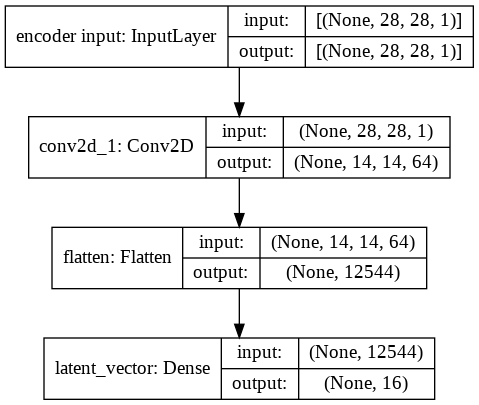

In [14]:
encoder = Model(inputs=inputs, outputs=latent, name='encoder')
tf.keras.utils.plot_model(encoder, show_shapes=True)

In [15]:
decoder_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense((shape[1]*shape[2]*shape[3]))(decoder_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)
for filter in n_filters:
  x = Conv2DTranspose(
      filters=filter,
      kernel_size = kernel_size,
      strides=2,
      activation='relu',
      padding='same'
  )(x)
x = tf.keras.layers.MaxPool2D(2)(x)
outputs = Conv2DTranspose(filters=1,
                          kernel_size = kernel_size,
                          padding='same',
                          activation='sigmoid'
                          )(x)  

In [16]:
decoder = Model(decoder_inputs, outputs, name='decoder')

In [17]:
autoencoder = Model(inputs=inputs, outputs = decoder(encoder(inputs)), name='autoencoder')

In [18]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Functional)         (None, 16)                201360    
_________________________________________________________________
decoder (Functional)         (None, 28, 28, 1)         250785    
Total params: 452,145
Trainable params: 452,145
Non-trainable params: 0
_________________________________________________________________


In [19]:
autoencoder.compile(optimizer='adam',
                    loss='mse',
                    metrics=['accuracy']
)

In [20]:
history = autoencoder.fit(
    x_train_noise,
    x_train,
    batch_size,
    10,
    validation_data = (x_test_noise, x_test),
)

Epoch 1/10
1875/1875 [==============================] - 49s 9ms/step - loss: 0.0588 - accuracy: 0.8052 - val_loss: 0.0217 - val_accuracy: 0.8086
Epoch 2/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0212 - accuracy: 0.8088 - val_loss: 0.0195 - val_accuracy: 0.8092
Epoch 3/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0192 - accuracy: 0.8102 - val_loss: 0.0189 - val_accuracy: 0.8099
Epoch 4/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0181 - accuracy: 0.8108 - val_loss: 0.0184 - val_accuracy: 0.8099
Epoch 5/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0175 - accuracy: 0.8109 - val_loss: 0.0183 - val_accuracy: 0.8094
Epoch 6/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0169 - accuracy: 0.8113 - val_loss: 0.0183 - val_accuracy: 0.8094
Epoch 7/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0165 - accuracy: 0.8120 - val_loss: 0.0182 - val_ac

In [21]:
x_decoded = autoencoder.predict(x_test_noise)

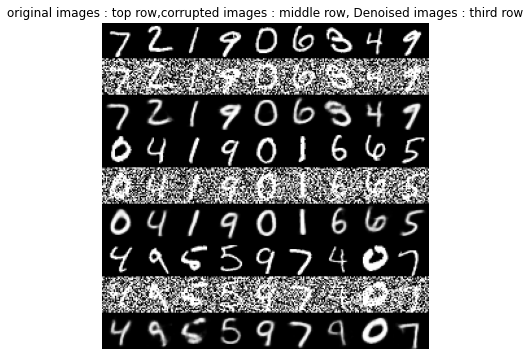

In [27]:
rows, cols = 3, 9
num = rows*cols 
imgs = np.concatenate([x_test[:num], x_test_noise[:num], x_decoded[:num]])
imgs = imgs.reshape((rows*3, cols, image_size, image_size))
imgs = np.vstack(np.split(imgs, rows, axis=1))
imgs = imgs.reshape((rows*3, -1, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs*255).astype(np.uint8)
plt.figure(figsize=(6, 6))
plt.axis('off')
plt.title('original images : top row,'
          'corrupted images : middle row, '
            'Denoised images : third row')
plt.imshow(imgs, interpolation=None, cmap='gray')
Image.fromarray(imgs).save('currupted_and_denoised.jpg')
plt.show()